In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller


In [2]:
df = pd.read_csv('DataCoSupplyChainDataset.csv',encoding = 'ISO-8859-1')
df.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id', 'order date ',
       'Order Id', 'Order Item Cardprod Id', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Item Total', 'Order Profit Per Order', 'Order Region',
       'Order State', 'Order Status', 'Order Zipcode', 'Product Card Id',
       'Product Category Id', 'Product Description', 'Produc

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [7]:
print(df.isnull().sum())


Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


In [11]:
# Selecting relevant columns
columns_of_interest = ['order date ', 'Sales', 'Benefit per order', 'Order Item Total']
selected_data = df[columns_of_interest]

In [13]:
# Convert 'order date ' to datetime format
selected_data['order date '] = pd.to_datetime(selected_data['order date '], errors='coerce')


C:\Users\Hi\AppData\Local\Temp\ipykernel_7588\1359616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['order date '] = pd.to_datetime(selected_data['order date '], errors='coerce')


In [15]:
# Aggregating data to a monthly level by summing up the values for each month
selected_data = selected_data.set_index('order date ')
monthly_data = selected_data.resample('M').sum()

C:\Users\Hi\AppData\Local\Temp\ipykernel_7588\3547194204.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = selected_data.resample('M').sum()


In [17]:
# Display the first few rows of the aggregated data
print(monthly_data.head())

                    Sales  Benefit per order  Order Item Total
order date                                                    
2015-01-31   1.051590e+06      111660.740132     945382.160534
2015-02-28   9.270099e+05       99140.660196     833012.429253
2015-03-31   1.051254e+06      113778.210191     944050.110472
2015-04-30   1.014463e+06      108083.679957     912004.400261
2015-05-31   1.050478e+06      112147.900143     943939.769956


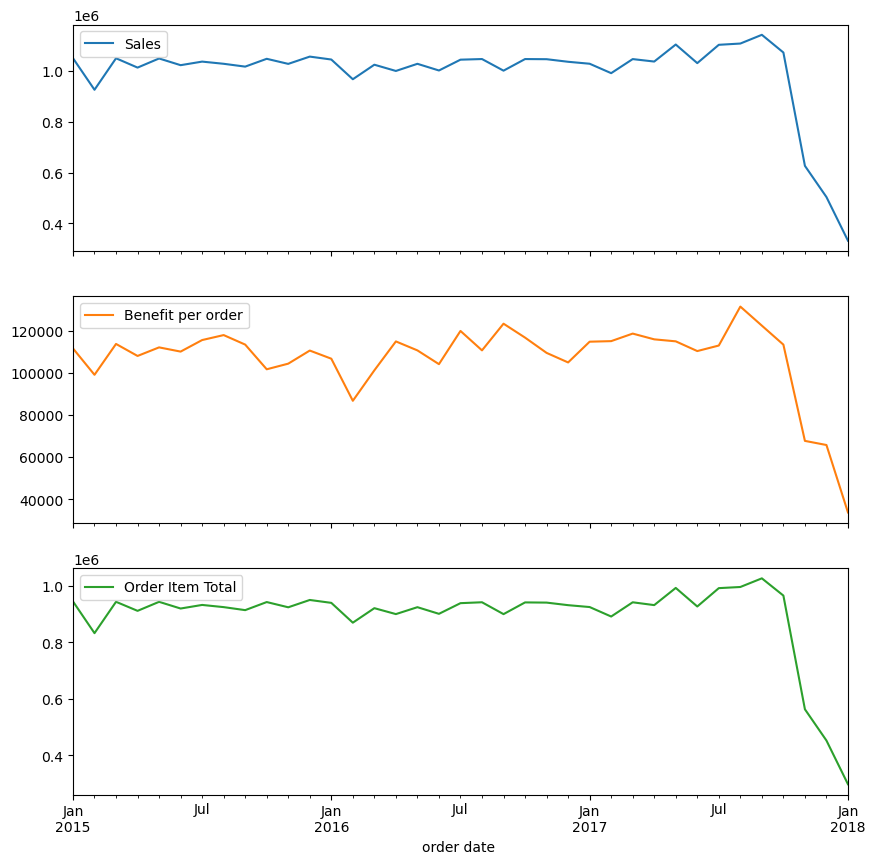

In [19]:
# Plotting the time series to understand their patterns
monthly_data.plot(subplots=True, figsize=(10, 10))
plt.show()

In [21]:
# Function to perform ADF test
def adf_test(series, column_name):
    adftest = adfuller(series.dropna())
    print(f'p-value of ADF test for {column_name} is: {adftest[1]}')

# Perform ADF test on each selected column
for column in ['Sales', 'Benefit per order', 'Order Item Total']:
    adf_test(monthly_data[column], column)

p-value of ADF test for Sales is: 0.0018019567638004259
p-value of ADF test for Benefit per order is: 0.9481505212858092
p-value of ADF test for Order Item Total is: 0.001775727880940341


In [25]:
# Differencing the 'Benefit per order' series
monthly_data['Benefit per order_diff'] = monthly_data['Benefit per order'].diff()


In [27]:
# ADF test on differenced series
adftest_diff = adfuller(monthly_data['Benefit per order_diff'].dropna())
print(f'p-value of ADF test for differenced Benefit per order is: {adftest_diff[1]}')

p-value of ADF test for differenced Benefit per order is: 8.537680201622897e-07


In [31]:
# Function to check stationarity and difference if necessary
def check_stationarity_and_difference(series, column_name):
    adftest = adfuller(series.dropna())
    p_value = adftest[1]
    print(f'p-value of ADF test for {column_name} is: {p_value}')
    if p_value > 0.05:
        print(f'{column_name} is non-stationary. Differencing...')
        series_diff = series.diff().dropna()
        adftest_diff = adfuller(series_diff)
        print(f'p-value of ADF test for differenced {column_name} is: {adftest_diff[1]}')
        return series_diff
    else:
        print(f'{column_name} is stationary.')
        return series

# Check and difference if necessary for 'Sales' and 'Order Item Total'
monthly_data['Sales'] = check_stationarity_and_difference(monthly_data['Sales'], 'Sales')
monthly_data['Order Item Total'] = check_stationarity_and_difference(monthly_data['Order Item Total'], 'Order Item Total')

# Dropping NaN values that may have been introduced by differencing
monthly_data = monthly_data.dropna()

# Now proceed with VAR model fitting and forecasting


p-value of ADF test for Sales is: 0.0018019567638004259
Sales is stationary.
p-value of ADF test for Order Item Total is: 0.001775727880940341
Order Item Total is stationary.


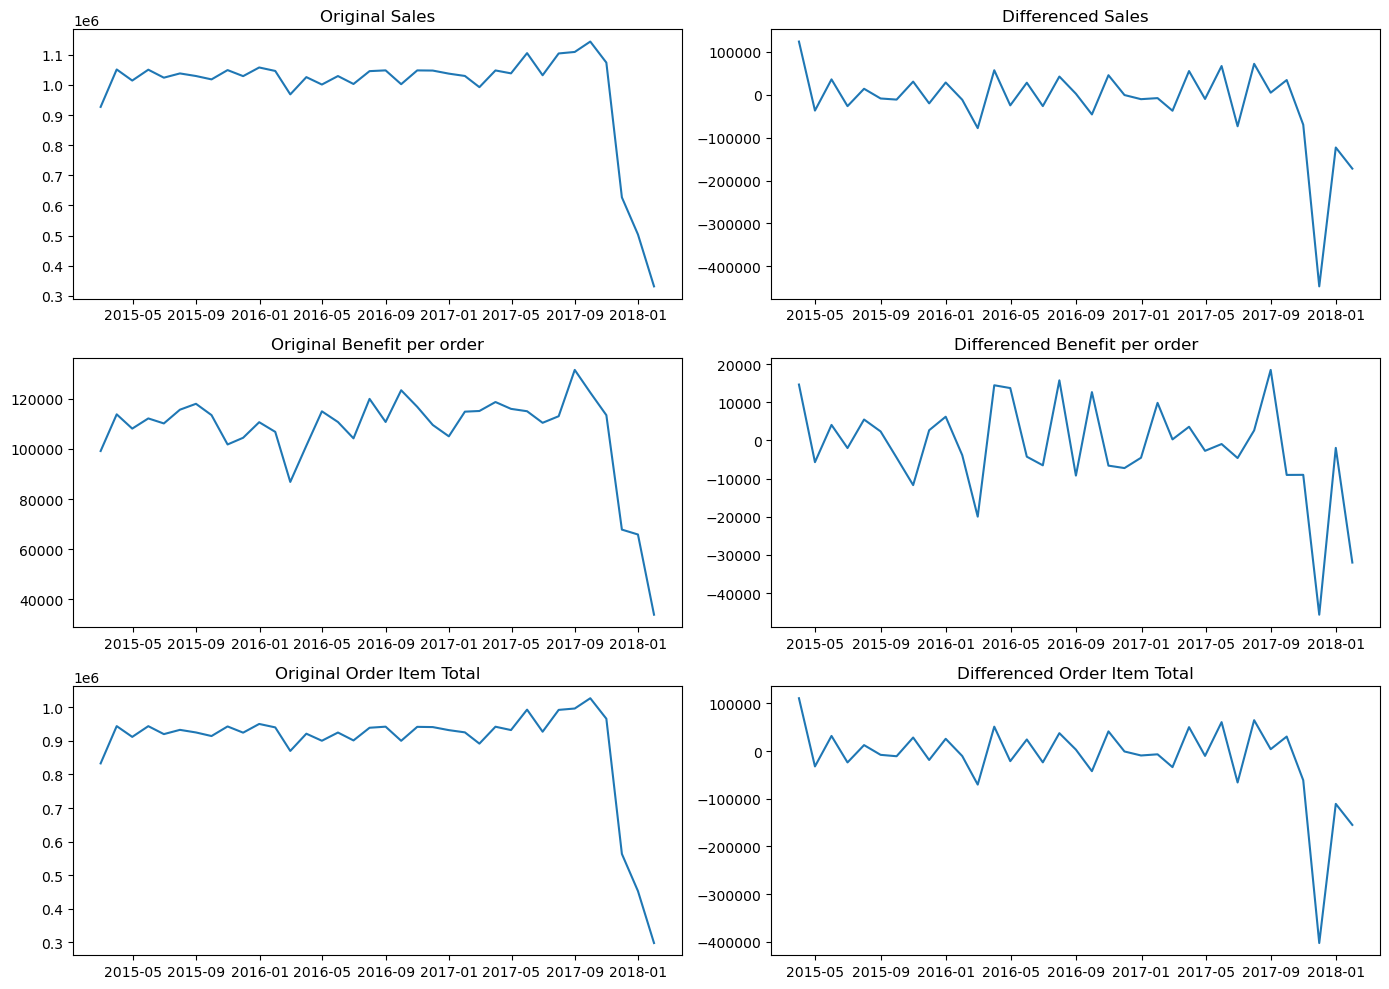

In [35]:
import matplotlib.pyplot as plt

# Plotting the original and differenced series
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))

# Original series
axes[0, 0].plot(monthly_data.index, monthly_data['Sales'])
axes[0, 0].set_title('Original Sales')
axes[1, 0].plot(monthly_data.index, monthly_data['Benefit per order'])
axes[1, 0].set_title('Original Benefit per order')
axes[2, 0].plot(monthly_data.index, monthly_data['Order Item Total'])
axes[2, 0].set_title('Original Order Item Total')

# Differenced series
axes[0, 1].plot(monthly_data.index[1:], monthly_data['Sales'].diff().dropna())
axes[0, 1].set_title('Differenced Sales')
axes[1, 1].plot(monthly_data.index[1:], monthly_data['Benefit per order'].diff().dropna())
axes[1, 1].set_title('Differenced Benefit per order')
axes[2, 1].plot(monthly_data.index[1:], monthly_data['Order Item Total'].diff().dropna())
axes[2, 1].set_title('Differenced Order Item Total')

plt.tight_layout()
plt.show()


# VAR Model:
### After ensuring all series are stationary, you can proceed with building the Vector Autoregression (VAR) model for forecasting and analysis.

# Assumptions:
1. Stationarity: The time series data must be stationary. If the data is not stationary, it needs to be differenced or transformed.
2. No Multicollinearity: The predictors should not be perfectly collinear.
3. White Noise Residuals: The residuals should ideally be white noise, meaning they have a constant mean and variance and are not autocorrelated.

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 31, Jul, 2024
Time:                     11:47:50
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    36.7095
Nobs:                     35.0000    HQIC:                   36.1275
Log likelihood:          -805.514    FPE:                3.63209e+15
AIC:                      35.8207    Det(Omega_mle):     2.94230e+15
--------------------------------------------------------------------
Results for equation Sales
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                       -139901.698076    168137.667304           -0.832           0.405
L1.Sales                         81.798285        36.938389            2.214           0.027
L1.Benefit p

C:\Users\Hi\AppData\Local\Temp\ipykernel_7588\3570491863.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=monthly_data.index[-1] + pd.Timedelta(days=1), periods=n_forecast, freq='M'), columns=monthly_data.columns)


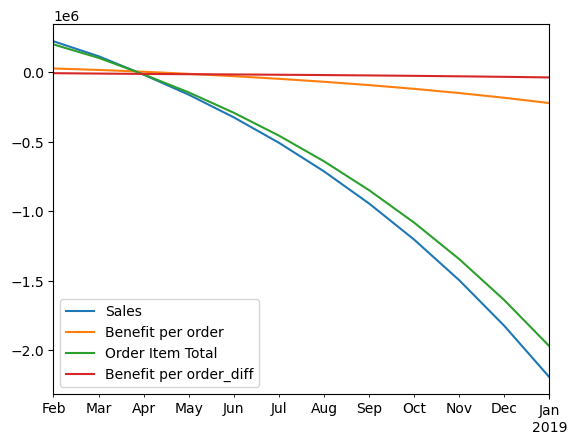

In [59]:
from statsmodels.tsa.api import VAR

# Fit the VAR model
model = VAR(monthly_data)
model_fitted = model.fit(maxlags=1, ic='aic')

# Summary of the model
print(model_fitted.summary())

# Forecasting
n_forecast = 12  # Number of steps to forecast
forecast_input = monthly_data.values[-model_fitted.k_ar:]
forecast = model_fitted.forecast(y=forecast_input, steps=n_forecast)

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=monthly_data.index[-1] + pd.Timedelta(days=1), periods=n_forecast, freq='M'), columns=monthly_data.columns)
print(forecast_df)

# Plotting forecasted values
forecast_df.plot()
plt.show()


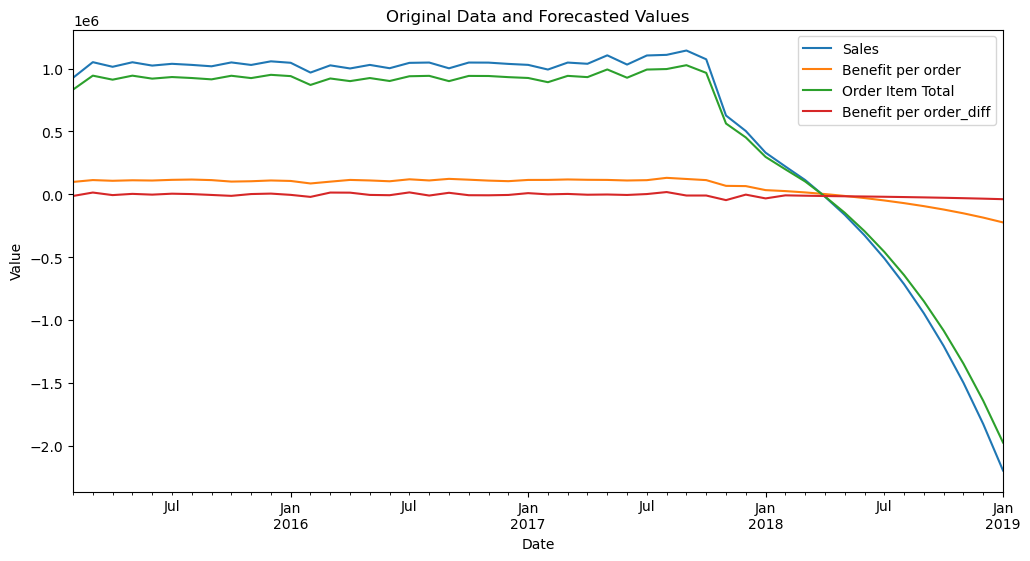

In [61]:
# Combine the original data with the forecasted data
combined_df = pd.concat([monthly_data, forecast_df])

# Plotting the original and forecasted values
combined_df.plot(figsize=(12, 6), title='Original Data and Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()
